## Description

Produce a plot showing what fraction of the genome is covered at different depths.

In [1]:
import ag3

In [2]:
v3 = ag3.release_data()

In [3]:
import numba
import numpy as np
import dask.array as da

In [4]:
import allel
import pandas as pd

In [5]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client, progress
import dask

In [6]:
dask_me = "kubernetes"

In [7]:
if dask_me == "kubernetes":
    # kubernetes cluster setup

    n_workers = 5
    cluster = KubeCluster()
    cluster.scale_up(n_workers)
    #cluster.adapt(minimum=1, maximum=n_workers)
    cluster

    # dask client setup

    client = Client(cluster)
    
    
elif dask_me == "single":
    dask.config.set(scheduler='threads')
    client = None
else:
    client = Client()
    
client

distributed.scheduler - INFO - Clear task state
/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:   tcp://10.35.63.10:41033
distributed.scheduler - INFO -   dashboard at:                    :41759
distributed.scheduler - INFO - Receive client connection: Client-d3ad7564-07c0-11eb-8361-faca4548bb18
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.35.63.10:41033 Dashboard: /user/nicholasharding/proxy/41759/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [8]:
sample_sets = v3.all_wild_sample_sets

In [9]:
all_meta = v3.load_sample_set_metadata(sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [10]:
chromosomes = "2L", "2R", "3L", "3R", "X"

In [11]:
males_select = all_meta.sex_call == "M"

select = (all_meta.species_gambcolu_arabiensis == "gamb_colu") & males_select

In [12]:
gt = v3.load_sample_set_calldata("X", sample_sets, field="GT")
gt = allel.GenotypeDaskArray(gt)
gt

distributed.scheduler - INFO - Register tcp://10.32.251.2:37429
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.251.2:37429
distributed.core - INFO - Starting established connection


<GenotypeDaskArray shape=(23385349, 2784, 2) dtype=int8>

In [13]:
gq = v3.load_sample_set_calldata("X", sample_sets, field="GQ")
gq

,Array,Chunk
Bytes,130.21 GB,30.00 MB
Shape,"(23385349, 2784)","(300000, 50)"
Count,10635 Tasks,5304 Chunks
Type,int16,numpy.ndarray


In [14]:
gt_sel = gt.compress(select.values, axis=1)
gt_sel

<GenotypeDaskArray shape=(23385349, 220, 2) dtype=int8>

In [15]:
gq_sel = da.compress(select.values, gq, axis=1)
gq_sel

,Array,Chunk
Bytes,10.29 GB,15.00 MB
Shape,"(23385349, 220)","(300000, 25)"
Count,12273 Tasks,1638 Chunks
Type,int16,numpy.ndarray


In [16]:
gt_sel.shape

(23385349, 220, 2)

In [17]:
pd.crosstab(all_meta.sample_set, all_meta.sex_call)

sex_call,F,M,UKN
sample_set,,,
AG1000G-AO,77,4,0
AG1000G-BF-A,151,30,0
AG1000G-BF-B,74,28,0
AG1000G-BF-C,13,0,0
AG1000G-CD,44,32,0
AG1000G-CF,73,0,0
AG1000G-CI,80,0,0
AG1000G-CM-A,258,45,0
AG1000G-CM-B,97,0,0


In [18]:
het = gt_sel.is_het() & (gq_sel >= 30)
het

,Array,Chunk
Bytes,5.14 GB,7.50 MB
Shape,"(23385349, 220)","(300000, 25)"
Count,29460 Tasks,1638 Chunks
Type,bool,numpy.ndarray


In [19]:
het[:10].compute()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [20]:
gt[:10].compute()

<GenotypeArray shape=(10, 2784, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [21]:
gamb_colu_mask = v3.load_mask("X", "gamb_colu")
gamb_colu_mask

dask.array<from-zarr, shape=(23385349,), dtype=bool, chunksize=(300000,), chunktype=numpy.ndarray>

In [22]:
import ag2

In [23]:
ag2_release_data = ag2.release_data()

def load_phase2_accessibility(chrom):
    
    phase2_is_accessible = ag2_release_data.load_is_accessible(chrom)
    filter_n = ag2_release_data.load_filter_n(chrom)
    phase2_is_accessible_nonN = da.compress(~filter_n, phase2_is_accessible, axis=0)

    # Compute chunk sizes avoids this error when concatenating arrays: ValueError: Arrays chunk sizes are unknown: (nan,)
    phase2_is_accessible_nonN.compute_chunk_sizes() 
    return phase2_is_accessible_nonN

phase2_mask = load_phase2_accessibility("X")

In [24]:
het_filtered = da.compress(gamb_colu_mask, het, axis=0)

het_filtered_phase2 = da.compress(phase2_mask, het, axis=0)

In [25]:
is_called = gt_sel.is_called() & (gq_sel >= 30)

In [26]:
is_called[:10].compute()

array([[ True, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True],
       ...,
       [ True, False, False, ..., False,  True,  True],
       [ True, False, False, ..., False,  True,  True],
       [ True, False, False, ..., False,  True,  True]])

In [27]:
is_called_sum_all = is_called.sum(axis=0).compute()

In [28]:
is_called_sum_filtered = da.compress(gamb_colu_mask, is_called, axis=0).sum(axis=0).compute()

In [29]:
is_called_sum_filtered_phase2 = da.compress(phase2_mask, is_called, axis=0).sum(axis=0).compute()

distributed.scheduler - INFO - Remove worker tcp://10.32.251.2:37429
distributed.core - INFO - Removing comms to tcp://10.32.251.2:37429
distributed.scheduler - INFO - Lost all workers
distributed.scheduler - INFO - Register tcp://10.33.13.4:36747
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.13.4:36747
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.21.3:33451
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.21.3:33451
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.229.4:35977
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.229.4:35977
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.11.4:39507
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.11.4:39507
distributed.core - INFO - Starting establis

In [30]:
het_sum_all = het.sum(axis=0).compute()
het_sum_filtered = het_filtered.sum(axis=0).compute()
het_sum_filtered_phase2 = het_filtered_phase2.sum(axis=0).compute()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://10.35.63.10:38594 remote=tcp://10.35.63.10:41033>


In [31]:
pre_filtering_mer = het_sum_all / is_called_sum_all
post_filtering_mer = het_sum_filtered / is_called_sum_filtered

In [32]:
phase2_filtering_mer = het_sum_filtered_phase2 / is_called_sum_filtered_phase2

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

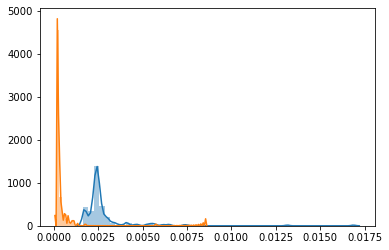

In [34]:
sns.distplot(pre_filtering_mer, label="pre")
sns.distplot(post_filtering_mer, label="post")

In [35]:
pre_des = pd.Series(pre_filtering_mer).describe()
pre_des

count    220.000000
mean       0.002808
std        0.001552
min        0.001648
25%        0.002269
50%        0.002441
75%        0.002678
max        0.016869
dtype: float64

In [36]:
post_des = pd.Series(post_filtering_mer).describe()
post_des

count    220.000000
mean       0.000372
std        0.000699
min        0.000160
25%        0.000206
50%        0.000227
75%        0.000318
max        0.008527
dtype: float64

In [37]:
p2_des = pd.Series(phase2_filtering_mer).describe()
p2_des * 100

count    22000.000000
mean         0.043289
std          0.086044
min          0.015835
25%          0.024031
50%          0.028747
75%          0.034838
max          1.038744
dtype: float64

In [38]:
gamb_colu_mask.mean().compute()

0.6997034339748361

In [39]:
phase2_mask.mean().compute()

0.6246213815325142

In [40]:
## Make table
out_df = pd.concat([pre_des, post_des], axis=1, keys=["pre-filtering", "post-filtering"])

# drop std because non-normal
out_df = out_df.T.drop(["std"], axis=1)

In [41]:
out_df["fraction_accessible"] = (1.0, gamb_colu_mask.mean().compute())

In [42]:
out_df.to_csv("../content/tables/site-filters/male_X_heterozygosity_rates.csv", float_format="%.5f")

In [43]:
fold = np.log2(post_filtering_mer) - np.log2(pre_filtering_mer)
pd.Series(fold).describe()

count    220.000000
mean      -3.229157
std        0.401916
min       -3.685262
25%       -3.478854
50%       -3.330376
75%       -3.150499
max       -0.624572
dtype: float64

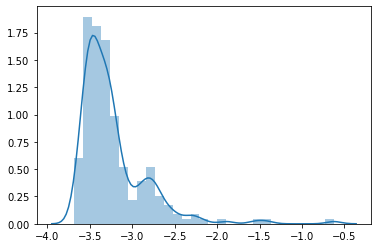

In [44]:
sns.distplot(fold)

In [45]:
out_df * 100

,count,mean,min,25%,50%,75%,max,fraction_accessible
pre-filtering,22000.0,0.280755,0.164819,0.226939,0.244119,0.267769,1.686927,100.000000
post-filtering,22000.0,0.037246,0.015978,0.020602,0.022732,0.031796,0.852733,69.970343
